In [183]:
import torch # V
import torchvision # V
import numpy as np # V
import matplotlib.pyplot as plt # V
from PIL import Image # V
from random import shuffle
from os import listdir # V
from os.path import isfile, splitext as os_path_splitext # V
from typing import Tuple, List, Dict, Generator, Any
import gc
from IPython.display import clear_output

# Dataset
**Gaofen Image Dataset**. Ref: https://x-ytong.github.io/project/GID.html

## Download

In [1]:
%%capture
!wget https://fruitourist.ru/cloud/gid_fine/image_RGB.zip
!wget https://fruitourist.ru/cloud/gid_fine/label_15classes.zip

In [2]:
%%capture
!unzip image_RGB.zip
!unzip label_15classes.zip

## Organization

In [117]:
!mkdir dataset dataset/labeleds

In [163]:
classes = {
    (0, 0, 0): (0, '__background__'),
    (200, 0, 0): (1, 'industrial_land'),
    # (250, 0, 150): (2, 'urban_residential'),
    # (200, 150, 150): (3, 'rural_residential'),
    # (250, 150, 150): (4, 'traffic_land'),
    # (0, 200, 0): (5, 'paddy_field'),
    # (150, 250, 0): (6, 'irrigated_land'),
    # (150, 200, 150): (7, 'dry_cropland'),
    # (200, 0, 200): (8, 'garden_plot'),
    # (150, 0, 250): (9, 'arbor_woodland'),
    # (150, 150, 250): (10, 'shrub_land'),
    # (250, 200, 0): (11, 'natural_grassland'),
    # (200, 200, 0): (12, 'artifical_grassland'),
    # (0, 0, 200): (13, 'river'),
    # (0, 150, 200): (14, 'lake'),
    # (0, 200, 250): (15, 'pond')
}

classes_by_id = dict()
for rgb, (id, name) in classes.items():
  classes_by_id[id] = (rgb, name)

In [6]:
def get_subimages_generator(
    image: Image.Image,
    subimage_size: Tuple[int, int, int]
) -> Generator[Image.Image, None, None]:
  for r in range(image.size[1] // subimage_size[1]):
    for c in range(image.size[0] // subimage_size[0]):
      yield image.crop(box=(
              c * subimage_size[0],
              r * subimage_size[1],
              (c + 1) * subimage_size[0],
              (r + 1) * subimage_size[1]
          )
      )

In [151]:
def save_dataset_subimages(classes_filter: Dict[Tuple[int, int, int], float]):

  for i, filename in enumerate(listdir('image_RGB/')):
      basename = filename[:filename.find('.tif')]
      
      image = Image.open(fp=f'image_RGB/{basename}.tif').crop(box=(16, 40, 7200 - 16, 6800 - 40))
      image_labeled = Image.open(fp=f'label_15classes/{basename}_label.tif').crop(box=(16, 40, 7200 - 16, 6800 - 40))
      subimages = get_subimages_generator(image=image, subimage_size=(224,224))
      subimages_labeleds = get_subimages_generator(image=image_labeled, subimage_size=(224,224))

      for si, subimage in enumerate(subimages):
        subimage_labeled = next(subimages_labeleds)
        
        # classes filter
        do_continue = False
        subimage_labeled_colors_dict = {rgb: count for count, rgb in subimage_labeled.getcolors()}
        for rgb, min_percent in classes_filter.items():
          if rgb not in subimage_labeled_colors_dict \
              or subimage_labeled_colors_dict[rgb] * 100 / 50176 < min_percent:
              # 50176 = subimage width * subimage height
            do_continue = True
            break
        if do_continue:
          continue

        subimage.save(fp=f'dataset/i{i}si{si}.tif')
        subimage_labeled.save(fp=f'dataset/labeleds/i{i}si{si}_labeled.tif')

In [149]:
save_dataset_subimages(
    classes_filter={
        (200, 0, 0): 5
    }
)

In [150]:
!ls -lR dataset/*.tif | wc -l

1377


## Support functions

In [20]:
def get_dataset_subimage(dataset_subimage_id: str) -> Tuple[Image.Image, Image.Image]:

  subimage = Image.open(fp=f'dataset/{dataset_subimage_id}.tif')
  subimage_labeled = Image.open(fp=f'dataset/labeleds/{dataset_subimage_id}_labeled.tif')

  return subimage, subimage_labeled

In [175]:
def get_subimage_mask_from_labeled(
    subimage_labeled: Image.Image,
    classes: Dict[Tuple[int, int, int], Tuple[int, str]]
) -> np.ndarray:

  subimage_mask = np.zeros(shape=(len(classes),subimage_labeled.size[0],subimage_labeled.size[1]))

  subimage_labeled_ndarray = np.array(object=subimage_labeled)
  for r in np.arange(stop=subimage_labeled_ndarray.shape[0]):
    for c in np.arange(stop=subimage_labeled_ndarray.shape[1]):
      class_rgb = tuple(subimage_labeled_ndarray[r][c])
      class_value = classes.get(class_rgb)
      if class_value:
        subimage_mask[class_value[0]][r][c] = 1.0
      else:
        subimage_mask[0][r][c] = 1.0

  return subimage_mask

In [182]:
def get_subimage_labeled_from_mask(
    subimage_mask: np.ndarray,
    classes_by_id: Dict[Tuple[int, int, int], Tuple[int, str]]
) -> Image.Image:

  subimage_labeled_ndarray = np.zeros(shape=(subimage_mask.shape[1],subimage_mask.shape[2],3))

  subimage_mask_hot = subimage_mask.argmax(axis=0)
  for r in np.arange(stop=subimage_mask_hot.shape[0]):
    for c in np.arange(stop=subimage_mask_hot.shape[1]):
      class_id = subimage_mask_hot[r][c]
      class_by_id_value = classes_by_id.get(class_id)
      subimage_labeled_ndarray[r][c] = np.array(object=class_by_id_value[0])
  
  subimage_labeled = Image.fromarray(obj=subimage_labeled_ndarray)
  
  return subimage_labeled

In [21]:
def subimage_preprocess(subimage: Image.Image) -> torch.Tensor:
  return torchvision.transforms.ToTensor()(pic=subimage)

In [29]:
def get_dataset_subimage_tensor(
    subimage: Image.Image,
    subimage_labeled: Image.Image,
    classes: Dict[Tuple[int, int, int], Tuple[int, str]],
    dtype: torch.FloatType,
) -> Tuple[torch.Tensor, torch.Tensor]:

  subimage_tensor = subimage_preprocess(image=subimage)
  subimage_mask_tensor = torch.tensor(
      data=get_subimage_mask_from_labeled(
          subimage_labeled=subimage_labeled,
          classes=classes
      ),
      dtype=dtype
  )

  return subimage_tensor, subimage_mask_tensor

In [ ]:
def get_dataset_generators(
    num_train_dataset: int,
    batch_size: int,
    classes: Dict[Tuple[int, int, int], Tuple[int, str]],
    shuffle: bool = True
) -> Tuple[
    Generator[Tuple[torch.Tensor, torch.Tensor], None, None],
    Generator[Tuple[torch.Tensor, torch.Tensor], None, None]
]:

  dataset_subimages_id = [
      filename[:filename.find('.tif')]
      for filename in listdir(path='dataset/') if isfile(path=f'dataset/{filename}')
  ]

  if shuffle:
    shuffle(x=dataset_subimages_id)

  train_dataset_subimages_id = dataset_subimages_id[:int(0.9 * len(dataset_subimages_id))] * num_train_dataset
  test_dataset_subimages_id = dataset_subimages_id[int(0.9 * len(dataset_subimages_id)):]

  def get_dataset_generator(
      dataset_subimages_id: List[str],
      batch_size: int,
      classes: Dict[Tuple[int, int, int], Tuple[int, str]]
  ) -> Generator[Tuple[torch.Tensor, torch.Tensor], None, None]:

    for b in range(round(len(dataset_subimages_id) / batch_size)):
      batch_subimages_tensor = list()
      batch_subimages_mask_tensor = list()
      for dataset_subimage_id in dataset_subimages_id[b * batch_size:(b + 1) * batch_size]:
        subimage = Image.open(fp=f'dataset/{dataset_subimage_id}.tif')
        subimage_labeled = Image.open(fp=f'dataset/labeled/{dataset_subimage_id}_labeled.tif')
        subimage_tensor, subimage_mask_tensor = get_dataset_subimage_tensor(
            subimage=subimage,
            subimage_labeled=subimage_labeled,
            classes=classes
        )
        batch_subimages_tensor.append(subimage_tensor.unsqueeze(dim=0))
        batch_subimages_mask_tensor.append(subimage_mask_tensor.unsqueeze(dim=0))
      batch_subimage_tensor = torch.cat(batch_subimages_tensor)
      batch_subimage_mask_tensor = torch.cat(batch_subimages_mask_tensor)
      yield batch_subimage_tensor, batch_subimage_mask_tensor
  
  dataset_generator_train = get_dataset_generator(
      dataset_subimages_id=train_dataset_subimages_id,
      batch_size=batch_size,
      classes=classes
  )
  dataset_generator_test = get_dataset_generator(
      dataset_subimages_id=test_dataset_subimages_id,
      batch_size=1,
      classes=classes
  )

  return dataset_generator_train, dataset_generator_test

## View

In [159]:
subimage, subimage_labeled = get_dataset_subimage(dataset_subimage_id='i0si100')

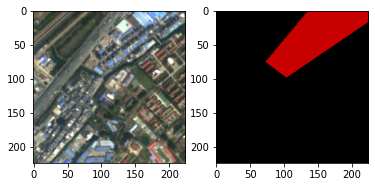

In [179]:
fig, ax = plt.subplots(ncols=2)
ax[0].imshow(subimage)
ax[1].imshow(subimage_labeled)
plt.show()

In [176]:
subimage_mask = get_subimage_mask_from_labeled(
    subimage_labeled=subimage_labeled,
    classes=classes
)

In [180]:
subimage_labeled_from_mask = get_subimage_labeled_from_mask(
    subimage_mask=subimage_mask,
    classes_by_id=classes_by_id
)

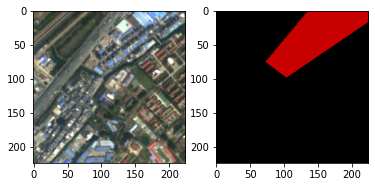

In [181]:
fig, ax = plt.subplots(ncols=2)
ax[0].imshow(subimage)
ax[1].imshow(subimage_labeled_from_mask)
plt.show()

# Model
FCN. Ref: https://arxiv.org/abs/1605.06211

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## Init

In [ ]:
model = torchvision.models.segmentation.fcn_resnet101(
    num_classes=len(classes),
    weights_backbone=torchvision.models.ResNet101_Weights
)

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights_backbone' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights_backbone=ResNet101_Weights.IMAGENET1K_V1`. You can also use `weights_backbone=ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
%%capture
if device.type == 'cuda':
  model.to(device=device)

**WARNING** Crutch

In [ ]:
model.load_state_dict(
    state_dict=torch.load(
        'drive/MyDrive/remezov_fcn_resnet101_eps1bs32.h5',
        map_location=device
    )
)

<All keys matched successfully>

## Pretest

In [ ]:
def predict(
    device: torch.DeviceObjType,
    model: torch.nn.Module,
    image: Image.Image
) -> Image.Image:

  image_tensor = image_preprocess(image=image)

  with torch.no_grad():
    output_image_mask = model(image_tensor.unsqueeze(0).to(device))['out'][0]
  
  predicted_image_labeled = get_subimage_labeled_from_mask(
      subimage_labeled_mask=output_image_mask.cpu(),
      classes=classes
  )

  return predicted_image_labeled

In [ ]:
subimage_tensor, subimage_mask_tensor = dataset_subimage_to_tensor(
    subimage=subimage,
    subimage_labeled=subimage_labeled,
    classes=classes
)

In [ ]:
predicted_image_labeled = predict(
    device=device,
    model=model,
    image=subimage
)

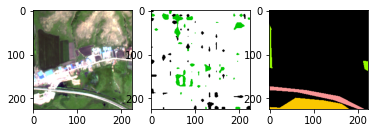

In [ ]:
fig, ax = plt.subplots(ncols=3)
ax[0].imshow(subimage)
ax[1].imshow(predicted_image_labeled)
ax[2].imshow(subimage_labeled)
plt.show()

## Metrics

In [ ]:
def metric_mean_pixel_accuracy(
    y_pred: torch.Tensor,
    y_true: torch.Tensor
) -> float:

  y_pred_hot = y_pred >= 0.51

  pixel_accuracies = list()
  for b in range(y_pred.shape[0]):
    correct_pixels = (y_pred_hot[b] == y_true[b]).count_nonzero()
    uncorrect_pixels = (y_pred_hot[b] != y_true[b]).count_nonzero()
    result = correct_pixels / (correct_pixels + uncorrect_pixels)
    pixel_accuracies.append(result)
  
  result = torch.mean(
      input=torch.tensor(data=pixel_accuracies)
  ).item()

  return result

In [ ]:
def metric_mean_iou(
    y_pred: torch.Tensor,
    y_true: torch.Tensor
) -> float:

  y_pred_hot = y_pred >= 0.51

  ious = list()
  for b in range(y_pred.shape[0]):
    intersection = torch.logical_and(y_pred_hot[b], y_true[b]).count_nonzero()
    union = torch.logical_or(y_pred_hot[b], y_true[b]).count_nonzero()
    result = intersection / union
    ious.append(result)
  
  result = torch.mean(
      input=torch.tensor(data=ious)
  ).item()

  return result

## Train

In [ ]:
def train(
    device: torch.DeviceObjType,
    model: torch.nn.Module,
    dataset_generator: Generator[Tuple[torch.Tensor, torch.Tensor], None, None],
    loss_fn: Any,
    optim_fn: Any,
    epochs: int,
    shindler: int = None
) -> Dict[str, List[float]]:

  history_metrics = {
      'loss': list(),
      'mean_pixel_accuracy': list(),
      'mean_iou': list()
  }

  for e in range(1, epochs + 1):
    for b, data in enumerate(dataset_generator, start=1):
      subimage_tensor, subimage_mask_tensor = data
      
      if device.type == 'cuda':
        subimage_tensor = subimage_tensor.to(device)
        subimage_mask_tensor = subimage_mask_tensor.to(device)
      
      optim_fn.zero_grad()
      output = model(subimage_tensor)
      loss = loss_fn(output['out'], subimage_mask_tensor)
      loss.backward()
      optim_fn.step()

      loss_item = loss.item()
      mean_pixel_accuracy = metric_mean_pixel_accuracy(output['out'], subimage_mask_tensor)
      mean_iou = metric_mean_iou(output['out'], subimage_mask_tensor)

      history_metrics['loss'].append(loss_item)
      history_metrics['mean_pixel_accuracy'].append(mean_pixel_accuracy)
      history_metrics['mean_iou'].append(mean_iou)

      clear_output()
      print('Epoch: {}. Batch: {}. Loss: {} | mAccuracy: {:.3f} | mIoU: {:.3f}'.format(
          e, b,
          loss_item, mean_pixel_accuracy, mean_iou
      ))

      del subimage_tensor
      del subimage_mask_tensor
      del output
      del loss
      del mean_pixel_accuracy
      del mean_iou
      if device.type == 'cuda':
        torch.cuda.empty_cache()
      
      if b == shindler:
        break
  
  return history_metrics

In [ ]:
dataset_generator_train, dataset_generator_test = get_dataset_generators(
    num_train_dataset=1,
    batch_size=1,
    classes=classes
)

*Loss function* is **CrossEntropyLoss**. Ref: https://arxiv.org/abs/1805.07836 \
*Optimization function* is **AdamW**. Ref: https://arxiv.org/abs/1711.05101

In [ ]:
history_metrics = train(
    device=device,
    model=model,
    dataset_generator=dataset_generator_train,
    loss_fn=torch.nn.CrossEntropyLoss(),
    optim_fn=torch.optim.AdamW(params=model.parameters()),
    epochs=1,
    shindler=8
)

In [ ]:
plt.plot(
    history_metrics['loss'], 'red',
    history_metrics['mean_pixel_accuracy'], 'green',
    history_metrics['mean_iou'], 'blue',
)
plt.title('History metrics: eps=1, bs=1, sh=8, optim=AdamW(lr=1e-3)')
plt.xlabel('Batch')
plt.ylabel('Value')
plt.legend(('Loss', 'mAccuracy', 'mIoU'))
plt.show()

**WARNING** Crutch

In [ ]:
torch.save(model.state_dict(), 'remezov_fcn_resnet101_eps1bs32sh100.h5')

In [ ]:
!mv remezov_fcn_resnet101_eps1bs32sh100.h5 drive/MyDrive

## Evaluate

In [ ]:
def evaluate(
    device: torch.DeviceObjType,
    model: torch.nn.Module,
    dataset_generator: Generator[Tuple[torch.Tensor, torch.Tensor], None, None],
    loss_fn: Any,
    shindler: int = None
) -> Dict[str, List[float]]:

  history_metrics = {
      'loss': list(),
      'mean_pixel_accuracy': list(),
      'mean_iou': list()
  }

  for b, data in enumerate(dataset_generator_test):
    subimage_tensor, subimage_mask_tensor = data

    if device.type == 'cuda':
      subimage_tensor = subimage_tensor.to(device)
      subimage_mask_tensor = subimage_mask_tensor.to(device)
    
    output = model(subimage_tensor)
    loss = loss_fn(output['out'], subimage_mask_tensor).item()
    mean_pixel_accuracy = metric_mean_pixel_accuracy(output['out'], subimage_mask_tensor)
    mean_iou = metric_mean_iou(output['out'], subimage_mask_tensor)


    history_metrics['loss'].append(loss)
    history_metrics['mean_pixel_accuracy'].append(mean_pixel_accuracy)
    history_metrics['mean_iou'].append(mean_iou)

    clear_output()
    print('Batch: {}. median Loss: {}. median Accuracy: {:.3f}. median IoU: {:.3f}'.format(
        b,
        torch.median(input=torch.tensor(data=history_metrics['loss'])),
        torch.median(input=torch.tensor(data=history_metrics['mean_pixel_accuracy'])),
        torch.median(input=torch.tensor(data=history_metrics['mean_iou']))
    ))

    del subimage_tensor
    del subimage_mask_tensor
    del output
    del loss
    del mean_pixel_accuracy
    del mean_iou
    if device.type == 'cuda':
      torch.cuda.empty_cache()
    
    if b == shindler:
      break
  
  return history_metrics

In [ ]:
history_metrics = evaluate(
    device=device,
    model=model,
    dataset_generator=dataset_generator_test,
    loss_fn=torch.nn.CrossEntropyLoss(),
    shindler=8
)

# Research

## Rosenbrock Function

In [ ]:
rosenbrock = lambda x, y: (x - 1)**2 + 100 * (y - x**2)**2

In [ ]:
X = np.arange(start=-1, stop=1, step=0.1)
Y = np.arange(start=-1, stop=1, step=0.1)

In [ ]:
X, Y = np.meshgrid(X, Y)
Z = rosenbrock(X, Y)

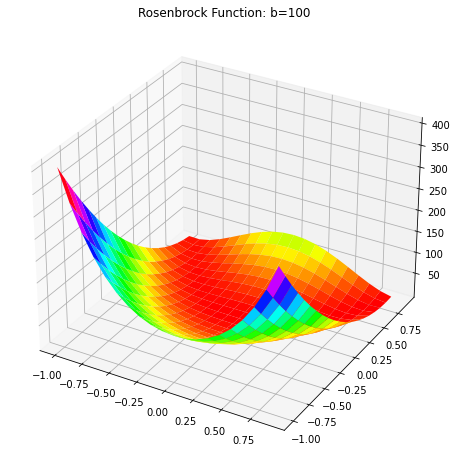

In [ ]:
fig = plt.figure(figsize=(16,8))
ax = fig.add_subplot(projection='3d')
ax.plot_surface(X, Y, Z, cmap='hsv')
plt.title('Rosenbrock Function: b=100')
plt.show()